# Load Winoground (enter a huggingface user token or it will fail)

Easily get a token by logging into https://huggingface.co/, clicking on your user profile -> settings -> access tokens -> new token

In [1]:
from datasets import load_dataset
auth_token = ""  # Replace with an auth token, which you can get from your huggingface account: Profile -> Settings -> Access Tokens -> New Token
winoground = load_dataset("facebook/winoground", use_auth_token=auth_token)["test"]

Reusing dataset winoground (/home/mengyan3/.cache/huggingface/datasets/facebook___winoground/default/0.0.0/ce486f3e39fab90997d6f3c58c4b0103eb9c37011049ef775a465f0ab2e78d7d)


# Load CLIP

In [2]:
from transformers import CLIPProcessor, CLIPModel
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Look at an example from Winoground and get the image-caption scores from CLIP

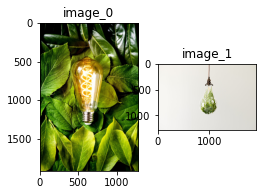

caption_0: some plants surrounding a lightbulb
caption_1: a lightbulb surrounding some plants

CLIP image-text match scores:
image_0, caption_0: 32.425514221191406
image_0, caption_1: 33.014556884765625
image_1, caption_0: 32.718040466308594
image_1, caption_1: 32.888797760009766


In [3]:
from matplotlib import pyplot as plt

ax1 = plt.subplot(1, 3, 1)
ax1.title.set_text('image_0')
plt.imshow(winoground[155]["image_0"].convert("RGB"))

ax2 = plt.subplot(1, 3, 2)
ax2.title.set_text('image_1')
plt.imshow(winoground[155]["image_1"].convert("RGB"))

plt.show()

print("caption_0:", winoground[155]["caption_0"])
print("caption_1:", winoground[155]["caption_1"])

# Note that some images in winoground are RGBA and some are RGB. Need to convert all to RGB with .convert('RGB')
# Note that we could run this example through CLIP as a batch, but I want to drive the point home that we get four independent image-caption scores for each example
input_c0_i0 = clip_processor(text=[winoground[155]["caption_0"]], images=[winoground[155]["image_0"].convert("RGB")], return_tensors="pt")
input_c1_i0 = clip_processor(text=[winoground[155]["caption_1"]], images=[winoground[155]["image_0"].convert("RGB")], return_tensors="pt")
input_c0_i1 = clip_processor(text=[winoground[155]["caption_0"]], images=[winoground[155]["image_1"].convert("RGB")], return_tensors="pt")
input_c1_i1 = clip_processor(text=[winoground[155]["caption_1"]], images=[winoground[155]["image_1"].convert("RGB")], return_tensors="pt")
output_c0_i0 = clip_model(**input_c0_i0)
output_c1_i0 = clip_model(**input_c1_i0)
output_c0_i1 = clip_model(**input_c0_i1)
output_c1_i1 = clip_model(**input_c1_i1)
clip_score_c0_i0 = output_c0_i0.logits_per_image.item()
clip_score_c1_i0 = output_c1_i0.logits_per_image.item()
clip_score_c0_i1 = output_c0_i1.logits_per_image.item()
clip_score_c1_i1 = output_c1_i1.logits_per_image.item()

print()
print("CLIP image-text match scores:")
print("image_0, caption_0:", clip_score_c0_i0)
print("image_0, caption_1:", clip_score_c1_i0)
print("image_1, caption_0:", clip_score_c0_i1)
print("image_1, caption_1:", clip_score_c1_i1)

# Get CLIP image-caption scores from the whole dataset

In [4]:
from tqdm import tqdm
from torch.nn import functional as F
import numpy as np
from scipy import spatial
import pdb
from transformers import AutoModelForMaskedLM, AutoTokenizer

# load text and image embeddings
with open("../data/clip_embs/image.npy", "rb") as f:
  image_embs = np.load(f)
  image_embs_flat = image_embs.reshape((image_embs.shape[0] * image_embs.shape[1], 512))
with open("../data/clip_embs/text.npy", "rb") as f:
  text_embs = np.load(f)
  text_embs_flat = text_embs.reshape((text_embs.shape[0] * text_embs.shape[1], 512))

roberta_model = AutoModelForMaskedLM.from_pretrained("roberta-base")
roberta_tokenizer = AutoModelForMaskedLM.from_pretrained("roberta-base")

# load text 
winoground_clip_scores = []
text_distances = []
image_distances = []
distance_gap = []
roberta_perplexities = []
for i, example in enumerate(tqdm(winoground)):
  # Note that some images in winoground are RGBA and some are RGB. Need to convert all to RGB with .convert('RGB')
  # Note that we could run this example through CLIP as a batch, but I want to drive the point home that we get four independent image-caption scores for each example
  input_c0_i0 = clip_processor(text=[example["caption_0"]], images=[example["image_0"].convert("RGB")], return_tensors="pt")
  input_c1_i0 = clip_processor(text=[example["caption_1"]], images=[example["image_0"].convert("RGB")], return_tensors="pt")
  input_c0_i1 = clip_processor(text=[example["caption_0"]], images=[example["image_1"].convert("RGB")], return_tensors="pt")
  input_c1_i1 = clip_processor(text=[example["caption_1"]], images=[example["image_1"].convert("RGB")], return_tensors="pt")
  output_c0_i0 = clip_model(**input_c0_i0)
  output_c1_i0 = clip_model(**input_c1_i0)
  output_c0_i1 = clip_model(**input_c0_i1)
  output_c1_i1 = clip_model(**input_c1_i1)
  
  clip_score_c0_i0 = output_c0_i0.logits_per_image.item()
  clip_score_c1_i0 = output_c1_i0.logits_per_image.item()
  clip_score_c0_i1 = output_c0_i1.logits_per_image.item()
  clip_score_c1_i1 = output_c1_i1.logits_per_image.item()
  
  # find text and image distances
  curr_img_embs = image_embs[i]
  curr_txt_embs = text_embs[i]
  img_dist = spatial.distance.cosine(curr_img_embs[0], curr_img_embs[1])
  txt_dist = spatial.distance.cosine(curr_txt_embs[0], curr_txt_embs[1])
  image_distances.append(img_dist)
  text_distances.append(txt_dist)
  distance_gap.append(txt_dist - img_dist)
  
  
  winoground_clip_scores.append({"id" : example["id"], "c0_i0": clip_score_c0_i0, "c0_i1": clip_score_c0_i1, "c1_i0": clip_score_c1_i0, "c1_i1": clip_score_c1_i1})

100%|██████████| 400/400 [08:02<00:00,  1.21s/it]


# Define the text, image, and group metrics, and compute the overall performance of CLIP

In [21]:
import pandas as pd

def text_correct(result):
    return result["c0_i0"] > result["c1_i0"] and result["c1_i1"] > result["c0_i1"]

def image_correct(result):
    return result["c0_i0"] > result["c0_i1"] and result["c1_i1"] > result["c1_i0"]

def group_correct(result):
    return image_correct(result) and text_correct(result)

winoground_roberta = pd.read_csv("../data/winoground_logprobs_davinci_test.csv").to_dict(orient="records")
text_correct_lst = []
image_correct_lst = []
group_correct_lst = []
equal_to_likely_caption = []
roberta_ppl_gap = []
clip_score_gap = []
relations = []
for result, roberta_data in zip(winoground_clip_scores, winoground_roberta):
  likely_c = roberta_data["likely_caption"]
  curr_text_correct = 1 if text_correct(result) else 0
  curr_img_correct = 1 if image_correct(result) else 0
  curr_group_correct = 1 if group_correct(result) else 0
  text_pred_0 = 0 if result["c0_i0"] > result["c1_i0"] else 1
  text_pred_1 = 0 if result["c0_i1"] > result["c1_i1"] else 1
  equal_to_likely_caption.extend([x == likely_c for x in [text_pred_0, text_pred_1]])

  text_correct_lst.append(curr_text_correct) 
  image_correct_lst.append(curr_img_correct) 
  group_correct_lst.append(curr_group_correct) 
  # do C0
  roberta_ppl_gap.append(roberta_data["prob_0"] - roberta_data["prob_1"])
  clip_score_gap.append(result["c0_i0"]/result["c1_i0"])
  relations.append(roberta_data["collapsed_tag"])
  


denominator = len(winoground_clip_scores)
text_correct_count = sum(text_correct_lst)
image_correct_count = sum(image_correct_lst)
group_correct_count = sum(group_correct_lst)
print("text score:", text_correct_count/denominator)
print("image score:", image_correct_count/denominator)
print("group score:", group_correct_count/denominator)
print("equal to likely caption:", sum(equal_to_likely_caption)/denominator)
print(text_correct_lst)
print(image_correct_lst)
print(group_correct_lst)
print(winoground_clip_scores)


text score: 0.3075
image score: 0.1025
group score: 0.0825
equal to likely caption: 0.9525
[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,

PointbiserialrResult(correlation=0.038487332229395294, pvalue=0.4427116890728672)


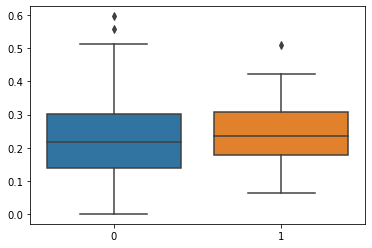

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr, pearsonr

abs_distance_gap = [abs(x) for x in distance_gap]
#sns.regplot(x=text_distances,y=text_correct_lst, logistic=True, ci=95)
#sns.regplot(x=abs_distance_gap,y=text_correct_lst, logistic=True, ci=95)
sns.boxplot(x=group_correct_lst, y=abs_distance_gap)
plt.savefig("../images/group_distance_correct_box.pdf")
plt.savefig("../images/group_distance_correct_box.png")
print(pointbiserialr(group_correct_lst, abs_distance_gap))

(0.020745613796641575, 0.6791243491893695)
(0.20677339432199077, 0.013890263339092315)


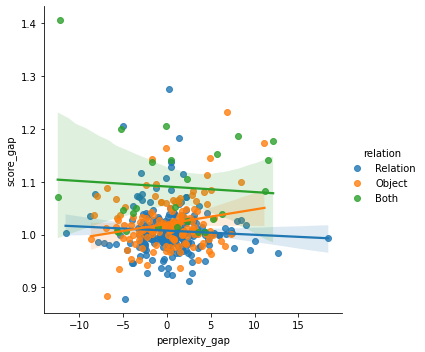

In [30]:
gap_df = pd.DataFrame({"logprobs_gap": roberta_ppl_gap, "score_gap": clip_score_gap, "relation": relations})
sns.lmplot(data=gap_df, x="logprobs_gap", y="score_gap", hue="relation")
plt.savefig("../images/perplexity_correctness.pdf")
plt.savefig("../images/perplexity_correctness.png")
print(pearsonr(roberta_ppl_gap, clip_score_gap))
ppl_objects = [x for i, x in enumerate(roberta_ppl_gap) if relations[i] == "Object"]
clip_objects = [x for i, x in enumerate(clip_score_gap) if relations[i] == "Object"]
print(pearsonr(ppl_objects, clip_objects))
